
# Fairness & Repair Exploratory Analysis
### Kushagra Ghosh

In data cleaning, the objective is to ensure that data can adhere to the right quality and integrity constraints. Our data has constraints (functional dependencies or FDs) that we want the database to satisfy (such as Zip Code -> City, State). There are countless algorithms for data repair that take in data and delete tuples, change values, or add different tuples to satisfy FDs using ML and statistics about the data. However, by changing the data, these repair algorithms may hurt one population. For example, by deleting a higher proportion of female tuples, there may be a lower percentage of females in the final data, swaying our statistics and create bias. We would like to verify our assumption that data repair algorithms can introduce bias. 

The idea of this exploration exercise is to see how query answers differ after specific data transformations. Specifically, does the data become distorted due to these transformations and then may lead the analyst to the wrong conclusion due to bias? 

### Original Census ACS PUMS Data

My first step was to retrive the dataset I am working with. Folktale is a package with various datasets, each with different tables and tasks to be predicted. I read the instructions and installed the package to work with the population dataset from here: https://github.com/zykls/folktables. This population dataset is from the American Community Survey Public Use Microdata Sample from https://www.census.gov/programs-surveys/acs/microdata/documentation.html.

In [11]:
%%capture
pip install folktables

In [12]:
from folktables import ACSDataSource, ACSIncome
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline


I generated a uniform random sample from each state with approximately 50% or 40% percentage for sex, and representation for different protected subpopulations (such as different races).

In [13]:
%%capture
data_source = ACSDataSource(survey_year='2021', horizon='1-Year', survey='person')
original = data_source.get_data(density=0.01,download=True)

I also varied the density and random seed of my sampling from the US population dataset to see if I would also get a consistent distribution. From here on, I will be using the Sample 1 (original) since I do get a consistent distribution.

In [14]:
#Varying the density and the random seed
us_data2 = data_source.get_data(density=0.002,random_seed=12,download=True)

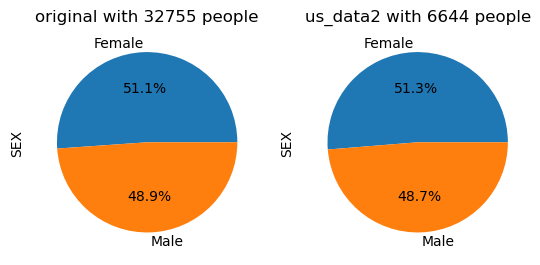

In [15]:
def piechart(title, df, ax, column, label_mapping):
    labels = df[column].value_counts().keys()
    df[column].value_counts().plot(kind="pie", autopct='%1.1f%%', ax=ax, labels =[label_mapping[l] for l in labels])
    ax.set_title(title)
    
fig, axs = plt.subplots(1, 2)
sex_label_mapping = {1: 'Male', 2: 'Female'}
piechart(f"original with {original.shape[0]} people", original, axs[0], 'SEX', sex_label_mapping)
piechart(f"us_data2 with {us_data2.shape[0]} people", us_data2, axs[1], 'SEX', sex_label_mapping)
plt.show()

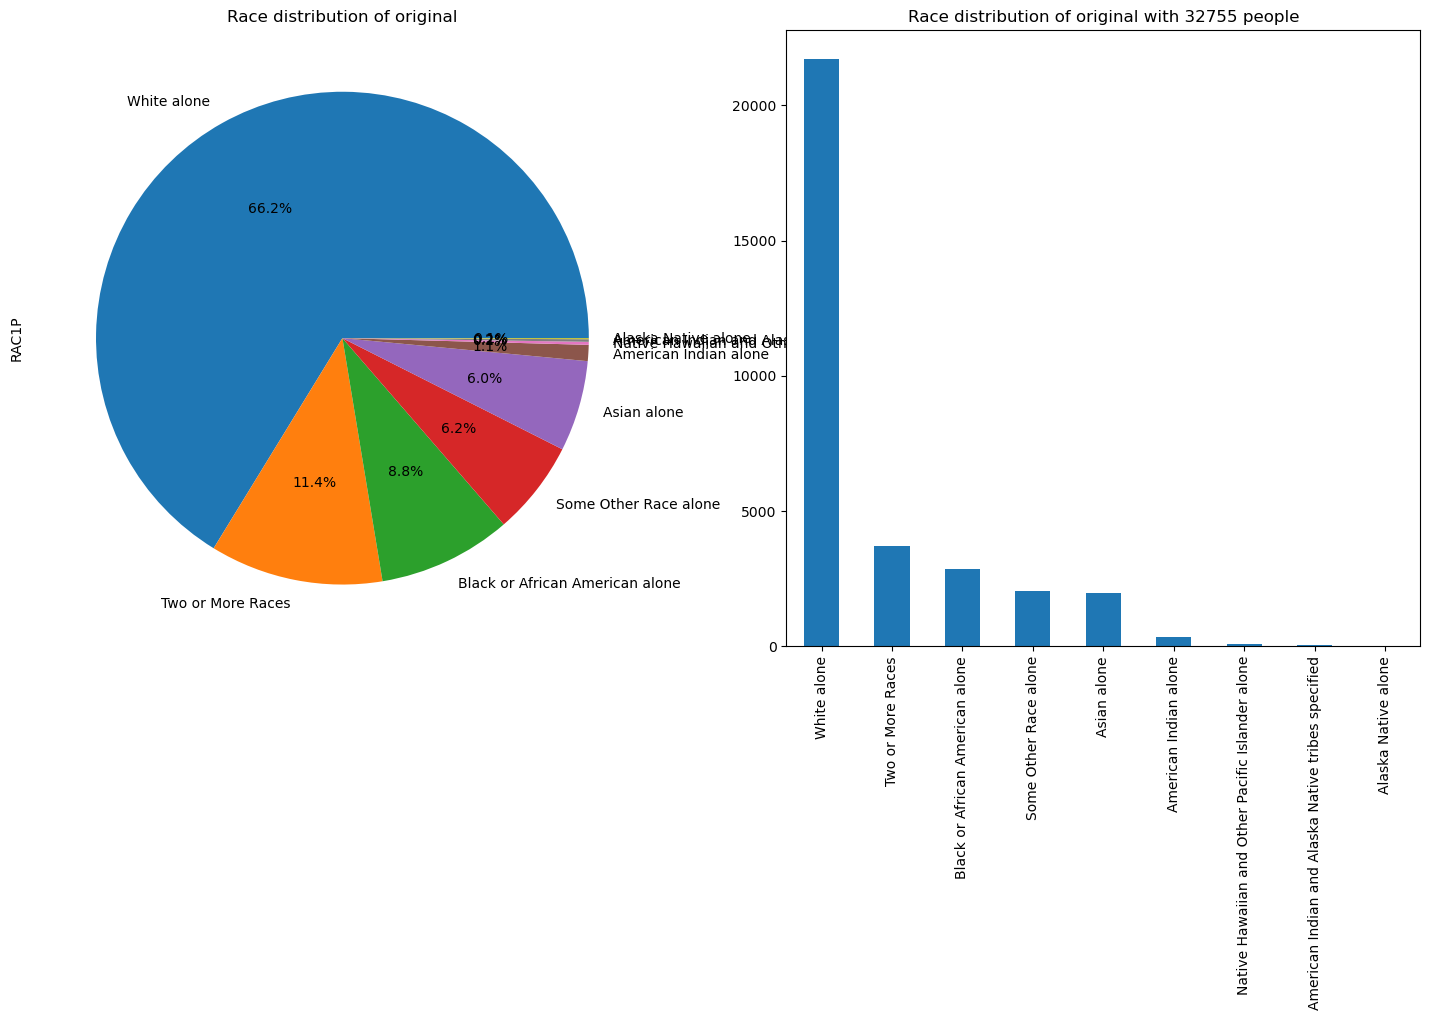

In [16]:
def barplotForCounts(title, df, ax, column, label_mapping):
    labels = df[column].value_counts().keys()
    df[column].value_counts().plot(kind="bar", ax=ax)
    ax.set_xticks(range(len(labels)), [label_mapping[l] for l in labels])
    #display(df[column].value_counts())
    ax.set_title(title)

fig, axs = plt.subplots(1,2, figsize=(18,8))
race_label_mapping = {1: 'White alone', 2: 'Black or African American alone', 3: 'American Indian alone', 4: 'Alaska Native alone', 5: 'American Indian and Alaska Native tribes specified', 6: 'Asian alone', 7: 'Native Hawaiian and Other Pacific Islander alone', 8: 'Some Other Race alone', 9: 'Two or More Races'}
piechart("Race distribution of original", original, axs[0], 'RAC1P', race_label_mapping)
barplotForCounts(f"Race distribution of original with {original.shape[0]} people", original, axs[1], 'RAC1P', race_label_mapping)
plt.show()

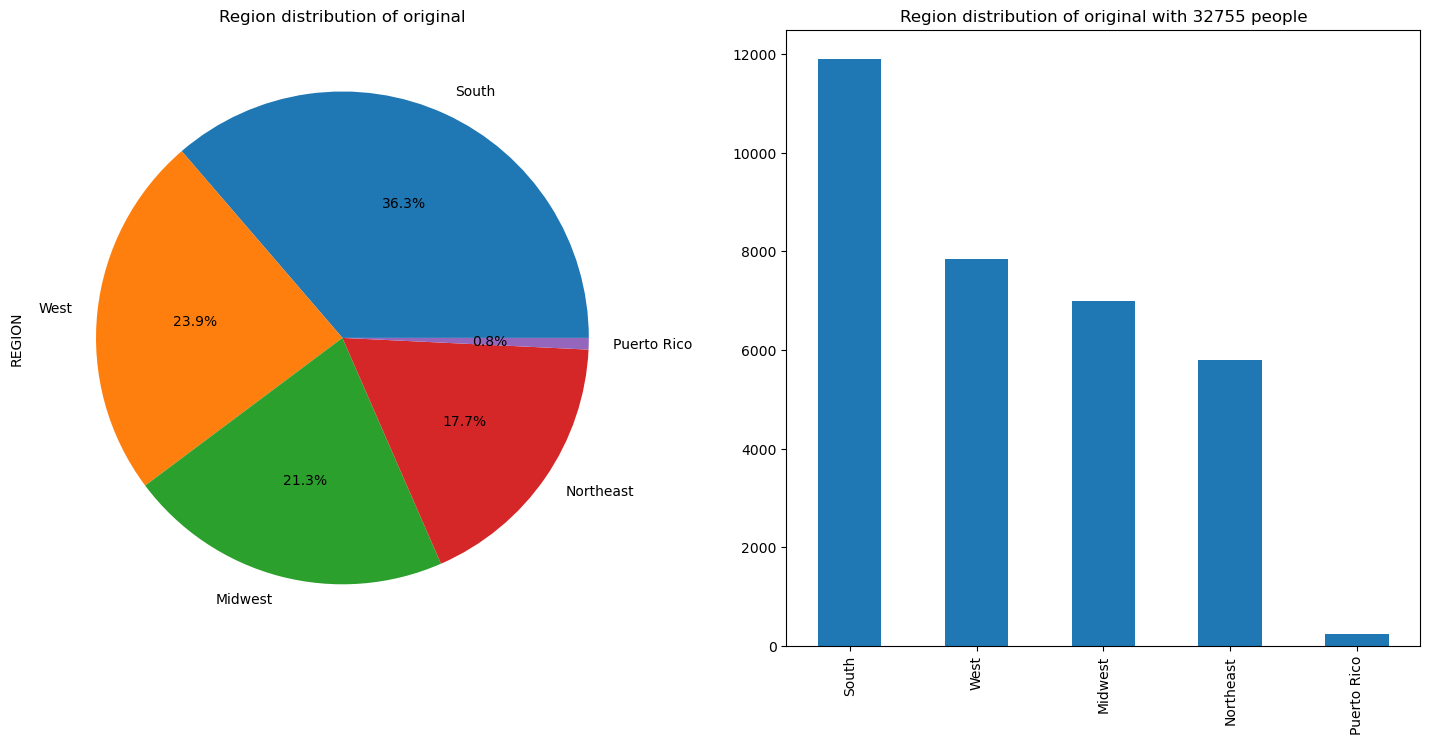

In [17]:
fig, axs = plt.subplots(1,2, figsize=(18,8))
region_label_mapping = {1: 'Northeast', 2: 'Midwest', 3: 'South', 4: 'West', 9: 'Puerto Rico'}
piechart("Region distribution of original", original, axs[0], 'REGION', region_label_mapping)
barplotForCounts(f"Region distribution of original with {original.shape[0]} people", original, axs[1], 'REGION', region_label_mapping)
plt.show()

I computed the average income for the entire population and for different protected subpopulations (different sexes, different races). I also computed the proportion of people making > 50k a year for the entire population. 

In [18]:
def average_income(df, column=None, value=None):
    df = df[df[column]==value] if column is not None else df
    return np.mean(df['PINCP'])

def proportion_above_50k(df, column=None, value=None):
    df = df[df[column]==value] if column is not None else df
    return df.loc[df['PINCP'] > 50000].shape[0]/df.shape[0]

print(f"Average income in original: ${average_income(original):.2f}")
print(f"Proportion of people making > 50K a year in original: {proportion_above_50k(original):.3%}")

Average income in original: $45093.63
Proportion of people making > 50K a year in original: 23.938%


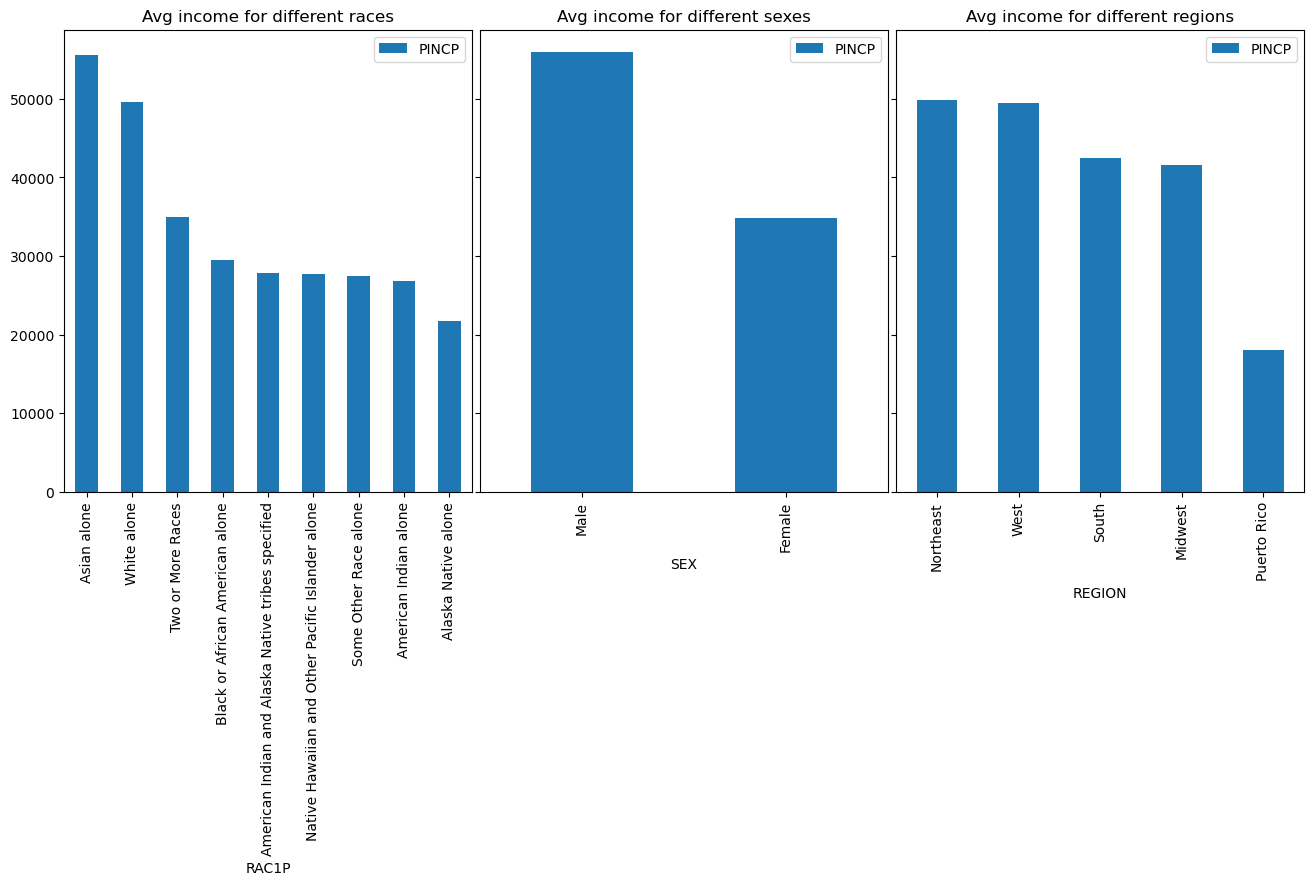

In [19]:
def barplotForAvg(title, df, column, ax, label_mapping):
    averages = df.pivot_table(values='PINCP', index=column, aggfunc='mean').sort_values(ascending=False, by='PINCP')
    labels = list(averages.index.values)
    averages.plot.bar(ax=ax)
    ax.set_xticks(range(len(labels)), [label_mapping[l] for l in labels])
    #ax.axhline(avg_income, color='red', linewidth=2)
    ax.set_title(title)
    
fig, axs = plt.subplots(1, 3, figsize=(16,6), sharey=True)
barplotForAvg("Avg income for different races", original, 'RAC1P', axs[0], race_label_mapping)
barplotForAvg("Avg income for different sexes", original, 'SEX', axs[1], sex_label_mapping)
barplotForAvg("Avg income for different regions", original, 'REGION', axs[2], region_label_mapping)

fig.subplots_adjust(wspace=0.02)
plt.show()

Then, I found a functional dependency (FD) that is satisfied by the data using https://github.com/USEPA/FDTool. I needed to make a python 2.7 environment with conda to run FDTool.

In [20]:
original = original[['RAC1P', 'SEX', 'REGION', 'PINCP', 'ST', 'COW', 'CIT', 'NATIVITY', 'MSP', 'SCHL', 'DIS','MIL']]
original.to_csv('original_census.csv',index=False)

In [21]:
fd_file = open("original_census.FD_Info.txt", "r")
print(fd_file.read())
fd_file.close()

Table : original_census
Columns : RAC1P, SEX, REGION, PINCP, ST, COW, CIT, NATIVITY, MSP, SCHL, DIS, MIL

Functional Dependencies: 
{ST} -> {REGION}
{CIT} -> {NATIVITY}

Equivalences: 

Keys: 
{RAC1P, SEX, PINCP, ST, COW, CIT, MSP, SCHL, DIS, MIL}

Time (s): 158.1423
Row count: 32755
Attribute count: 12
Number of Equivalences: 0
Number of FDs: 2
Number of FDs checked: 3839


I verified that the FD or DC makes sense and that the data doesn't violate the FD or DC before moving to the next step. 

Given two columns ST (state) and REGION (of the US), the approach I implemented to check for Functional Dependencies to first group by the values of the ST column and use the nunique() method to check number of unique values in REGION for each group in the ST column. If all of the values are 1, that means that there is a unique value for REGION for each each value in ST, which means that columns ST and REGION conform to a functional dependency.

In [22]:
def satisfiesFD(df, col1, col2):
    return df.groupby([col1])[col2].nunique().eq(1).all()
def satisfiesDC(df, col1, val1, col2, val2):
    return df[df[col1] == val1][col2].eq(val2).sum() == 0

print(satisfiesFD(original,'ST','REGION'))
print(satisfiesFD(original,'CIT','NATIVITY'))

True
True


### Synthetic Data Generation (without constraints)

Then, I generated synthetic data (with a machine learning model), which changes the values of the tuple but maintains the same number of tuples. With my new synthetic adult data, I will check how many violations of the Functional Dependencies and Denial Constraints I find, and how the various marginal distributions for income based on race, gender, education, and more is affected.

In [23]:
%%capture
pip install sdv

For the first synthetic data being generated from the original data (original), I decided to only use metadata about the numerical or categorical type of each attribute, and chose to specifically omit constraints such as the FixedConstraints (which is as close to Functional Dependencies or Denial Constraints as the SDV package offers). I will add these constraints in my second synthetic data generator that use the original data (original) and several constraints (FD or DC) that I observed in the data from above.

In [24]:
from sdv.metadata import SingleTableMetadata

def update_column(metadata, column_type, *args):
    for col in args:
        metadata.update_column(
            column_name=col,
            sdtype='categorical'
        )
        
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=original)
update_column(metadata, 'categorical', 'RAC1P', 'SEX', 'REGION', 'ST', 'COW', 'CIT', 'NATIVITY', 'MSP', 'SCHL', 'DIS', 'MIL')

I experimented with using several synthetic data generators (from the Synthetic Data Vault package found at https://docs.sdv.dev/sdv/single-table-data/modeling/synthesizers) using various Copulas and Deep Learning based models. Finally, I used the FAST ML Preset synthesizer from https://docs.sdv.dev/sdv/single-table-data/modeling/synthesizers/fast-ml-preset to generate new synthetic data from the original data (adult_data) due to its quicker runtime and more accurate distributions compared to the original dataset. 

Generating synthetic data (version 1) without constraints, which will eventually be cleaned with Holoclean and Muse.

In [25]:
from sdv.lite import SingleTablePreset

synthesizer = SingleTablePreset(metadata, name='FAST_ML')
synthesizer.fit(original)
synthetic_data = synthesizer.sample(num_rows=original.shape[0])
display(synthetic_data)

,RAC1P,SEX,REGION,PINCP,ST,COW,CIT,NATIVITY,MSP,SCHL,DIS,MIL
0,9,2,4,NaN,12,1.0,4,1,1.0,19.0,2,4.0
1,1,1,4,126359.506075,18,1.0,1,1,1.0,19.0,2,4.0
2,1,1,4,75127.858956,47,8.0,4,1,1.0,16.0,2,4.0
3,1,2,3,NaN,9,NaN,1,1,1.0,19.0,2,4.0
4,9,1,4,10790.547541,34,NaN,1,1,1.0,22.0,2,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
32750,1,2,2,NaN,41,1.0,1,1,6.0,4.0,2,4.0
32751,1,1,4,NaN,39,1.0,1,1,6.0,13.0,2,4.0
32752,1,2,2,93398.380846,15,6.0,1,1,6.0,21.0,2,4.0
32753,1,1,2,-1007.571261,8,NaN,1,1,NaN,1.0,2,NaN


### Synthetic Data Generation (with constraints)

I will test my claim about how synthetic data generators that don't consider integrity constraints doesn't preserve the full statistics and distributions of the original data because they don't fairly represent different protected subpopulations that appear less frequently in the original dataset. I will test this by creating another synthetic data generator with the same metadata but now with a combination of functional dependencies that was not present in the first synthetic data generator (which was called 'synthesizer'). 

I used FixedCombinations (https://docs.sdv.dev/sdv/reference/constraint-logic/predefined-constraint-classes) as a proxy for functional dependencies since FixedCombinations were one of the only constraints that the Synthetic Data Vault (SDV) generators take in that is closest to a FD (since they didn't have a way to explicitly define FDs).

In [26]:
fd = [['ST','REGION'], ['CIT','NATIVITY']]

def FixedCombinationsConstraint(fds):
    constraints = []
    for fd in fds:
        constraint = {
            'constraint_class': 'FixedCombinations',
            'constraint_parameters': {
                'column_names': fd
            }
        }
        constraints.append(constraint)
    return constraints

Generating synthetic data (version 2) with constraints

In [27]:
synthesizer2 = SingleTablePreset(metadata, name='FAST_ML')
synthesizer2.add_constraints(
    constraints=FixedCombinationsConstraint(fd)
)
synthesizer2.fit(original)
synthetic_data2 = synthesizer2.sample(num_rows=original.shape[0])
display(synthetic_data2)

Sampling rows: 100%|███████████████████| 32755/32755 [00:00<00:00, 57910.23it/s]


,RAC1P,SEX,REGION,PINCP,ST,COW,CIT,NATIVITY,MSP,SCHL,DIS,MIL
0,2,1,1,NaN,34,NaN,1,1,6.0,18.0,2,4.0
1,8,2,4,38393.426584,6,1.0,1,1,NaN,18.0,2,4.0
2,1,2,4,-8500.000000,56,1.0,1,1,1.0,21.0,2,4.0
3,1,1,3,NaN,47,3.0,1,1,1.0,22.0,2,4.0
4,1,1,2,92553.536861,29,1.0,1,1,NaN,21.0,2,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
32750,8,2,4,NaN,6,NaN,1,1,4.0,4.0,2,4.0
32751,1,2,4,NaN,8,NaN,1,1,1.0,18.0,2,4.0
32752,8,2,3,41345.910832,47,1.0,1,1,6.0,20.0,2,4.0
32753,1,2,1,15994.691291,25,3.0,1,1,1.0,22.0,2,4.0


In [28]:
synthetic_data.to_csv('synthetic_data_version_1.csv',index=False)

Then, I checked if the generated data satisfies the functional dependencies from above. I check if two columns form a FD by comparing the values at both columns for each tuple and checking if one column uniquely determined the other column. 

In [29]:
print("For the functional dependency between ST -> REGION:")
print(f"The original satisfies FD: {satisfiesFD(original,'ST','REGION')}\nThe synthetic_data without constraints satisfies FD: {satisfiesFD(synthetic_data,'ST','REGION')}")

print("\nFor the functional dependency between CIT -> NATIVITY:")
print(f"The original satisfies FD: {satisfiesFD(original,'CIT','NATIVITY')}\nThe synthetic_data satisfies FD: {satisfiesFD(synthetic_data,'CIT','NATIVITY')}")
                                                                                                                 

For the functional dependency between ST -> REGION:
The original satisfies FD: True
The synthetic_data without constraints satisfies FD: False

For the functional dependency between CIT -> NATIVITY:
The original satisfies FD: True
The synthetic_data satisfies FD: False


I also checked how many violations of the FDs are in the data. (i.e., how many pairs of tuples violate it) to quantify how noisy the new synthetic data is. In order to do this, I did a projection on my dataframe to get the relevant columns for the FD, and then I did a self join query with the column in the left side of the FD being equal but the column in the right side of the FD being not equal (for example for Col1 -> Col2, I set the join condition as A.Col1 = B.Col1 and A.Col2 != B.Col2). 

Then I counted how many tuples form a violation the new merged table, and divided this number by the maximum number of ways of joining two tuples together. This number is equal to the maximum number of violations possible in the new merge table, which turns out to be $tuples\space in \space original \space dataframe \choose 2$ . 

In [30]:
import math

def numberOfViolations(df, col1, col2):
    merging_data = df[[col1, col2]]
    num_rows = merging_data.shape[0]
    maxViolations = math.comb(num_rows,2)
    
    merging_data = merging_data.reset_index()
    merging_data = merging_data.append(merging_data.iloc[-1], ignore_index=True)
    
    result = pd.merge(merging_data, merging_data, how='inner', left_on=[col1], right_on=[col1], suffixes=('_left', '_right'))
    result = result[result['index_left'] > result['index_right']]
    result = result[result[f'{col2}_left'] != result[f'{col2}_right']]
    num_violations = result.shape[0]
    return f"{num_violations} pairs of tuples violate the {col1} -> {col2} FD. The maximum possible violations are {maxViolations}. The percentage is {num_violations/maxViolations:.3%}"

print(numberOfViolations(synthetic_data, 'ST', 'REGION'))
#print(numberOfViolations(synthetic_data, 'CIT', 'NATIVITY'))

/var/folders/2v/h3nv4s8x3wdgrb7zrb22vvt00000gn/T/ipykernel_5497/2594168524.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merging_data = merging_data.append(merging_data.iloc[-1], ignore_index=True)


16453090 pairs of tuples violate the ST -> REGION FD. The maximum possible violations are 536428635. The percentage is 3.067%


### Holoclean repair on synthetic data without constraints

In [31]:
%%capture
pip install psycopg2

In [32]:
import psycopg2

# Establish a connection to the PostgreSQL database
conn = psycopg2.connect(
    database="holo",
    user="holocleanuser",
    password="abcd1234"
)

# Execute an SQL query and create a dataframe hospital_repaired
holoclean_data = pd.read_sql("SELECT * FROM synthetic_data_version_1_repaired", conn).iloc[:, 1:]

conn.close()

#Alternatively, access the new hospital data from the terminal in holoclean with:  1.   --user postgres     2. \c holo    3. \dt
#4. \copy (SELECT * FROM hospital_repaired) to '/Users/kushagraghosh/Desktop/DataRepairAndFairness/hospital_repaired.csv' with csv header;


/Users/kushagraghosh/opt/anaconda3/lib/python3.8/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [33]:
display(holoclean_data)

,RAC1P,SEX,REGION,PINCP,ST,COW,CIT,NATIVITY,MSP,SCHL,DIS,MIL
0,9,2,4,_nan_,12,1.0,4,1,1.0,19.0,2,4.0
1,1,1,4,126359.50607515374,18,1.0,1,1,1.0,19.0,2,4.0
2,1,1,4,75127.85895569899,47,8.0,4,1,1.0,16.0,2,4.0
3,1,2,3,_nan_,9,_nan_,1,1,1.0,19.0,2,4.0
4,9,1,4,10790.54754111301,34,_nan_,1,1,1.0,22.0,2,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
32750,1,2,2,_nan_,41,1.0,1,1,6.0,4.0,2,4.0
32751,1,1,4,_nan_,39,1.0,1,1,6.0,13.0,2,4.0
32752,1,2,2,93398.38084596951,15,6.0,1,1,6.0,21.0,2,4.0
32753,1,1,2,-1007.571260918121,8,_nan_,1,1,_nan_,1.0,2,4.0


In [34]:
print(holoclean_data.isna().sum().sum())
print(holoclean_data.eq('_nan_').sum().sum())
holoclean_data = holoclean_data.replace('_nan_', np.nan)

def make_col_int(df, *args):
    for col in args:
        df[col] = df[col].astype(float)
        df[col] = df[col].astype(int)
def make_col_float(df, *args):
    for col in args:
        df[col] = df[col].astype(float)
        
make_col_int(holoclean_data, 'RAC1P', 'SEX', 'REGION', 'ST', 'CIT', 'NATIVITY', 'DIS')
make_col_float(holoclean_data, 'PINCP', 'COW', 'MSP', 'SCHL', 'MIL')

0
19648


In [35]:
display(holoclean_data)

,RAC1P,SEX,REGION,PINCP,ST,COW,CIT,NATIVITY,MSP,SCHL,DIS,MIL
0,9,2,4,NaN,12,1.0,4,1,1.0,19.0,2,4.0
1,1,1,4,126359.506075,18,1.0,1,1,1.0,19.0,2,4.0
2,1,1,4,75127.858956,47,8.0,4,1,1.0,16.0,2,4.0
3,1,2,3,NaN,9,NaN,1,1,1.0,19.0,2,4.0
4,9,1,4,10790.547541,34,NaN,1,1,1.0,22.0,2,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
32750,1,2,2,NaN,41,1.0,1,1,6.0,4.0,2,4.0
32751,1,1,4,NaN,39,1.0,1,1,6.0,13.0,2,4.0
32752,1,2,2,93398.380846,15,6.0,1,1,6.0,21.0,2,4.0
32753,1,1,2,-1007.571261,8,NaN,1,1,NaN,1.0,2,4.0


To check how many tuples were changed using the HoloClean repair process on the synthetic data without constraints:

In [36]:
comparing = synthetic_data.compare(holoclean_data)
display(comparing)
print(f"{round(comparing.isna().eq(False).sum().sum()/2)} cells were changed")
print(f"{comparing.shape[0]} tuples (rows) out of a total {synthetic_data.shape[0]} were changed")

COW        MSP       SCHL        MIL      
      self other self other self other self other
13     NaN   NaN  NaN   NaN  NaN   NaN  NaN   4.0
16     NaN   1.0  NaN   NaN  NaN   NaN  NaN   NaN
27     NaN   1.0  NaN   6.0  NaN   NaN  NaN   NaN
28     NaN   1.0  NaN   NaN  NaN   NaN  NaN   4.0
30     NaN   1.0  NaN   6.0  NaN   NaN  NaN   NaN
...    ...   ...  ...   ...  ...   ...  ...   ...
32735  NaN   NaN  NaN   NaN  NaN   NaN  NaN   4.0
32741  NaN   1.0  NaN   NaN  NaN   NaN  NaN   NaN
32744  NaN   1.0  NaN   NaN  NaN   NaN  NaN   NaN
32749  NaN   NaN  NaN   NaN  NaN   NaN  NaN   4.0
32753  NaN   NaN  NaN   NaN  NaN   NaN  NaN   4.0

[6421 rows x 8 columns]

3734 cells were changed
6421 tuples (rows) out of a total 32755 were changed


Since the Holoclean and other repair algorithms are probabilistic and not deterministic, we need to find the number of violations before repairing (after synthetic data generation) and after cleaning/repair (for Holoclean and Muse). For example in HoloClean, if the number of violations for functional dependencies is beyond some percentage in the data, it won't do anything to repair, so we should know if Holoclean gave up and did nothing.

In [37]:
print(numberOfViolations(synthetic_data, 'ST', 'REGION'))
print(numberOfViolations(holoclean_data, 'ST', 'REGION'))

/var/folders/2v/h3nv4s8x3wdgrb7zrb22vvt00000gn/T/ipykernel_5497/2594168524.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merging_data = merging_data.append(merging_data.iloc[-1], ignore_index=True)


16453090 pairs of tuples violate the ST -> REGION FD. The maximum possible violations are 536428635. The percentage is 3.067%


/var/folders/2v/h3nv4s8x3wdgrb7zrb22vvt00000gn/T/ipykernel_5497/2594168524.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merging_data = merging_data.append(merging_data.iloc[-1], ignore_index=True)


16453090 pairs of tuples violate the ST -> REGION FD. The maximum possible violations are 536428635. The percentage is 3.067%


### Multiple Semantics (MUSE) repair

Using the MUSE repair process on the synthetic data without constraints:

In [38]:
import psycopg2

# Establish a connection to the PostgreSQL database
conn = psycopg2.connect(
    database="cr",
    user="postgres",
    password="postgres"
)

# Execute an SQL query and create a dataframe hospital_repaired
muse_data = pd.read_sql("SELECT * FROM synthetic_data_version_1", conn)
muse_data.drop(muse_data.index[0])

conn.close()

/Users/kushagraghosh/opt/anaconda3/lib/python3.8/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [39]:
display(muse_data)

,rac1p,sex,region,pincp,st,cow,cit,nativity,msp,schl,dis,mil
0,RAC1P,SEX,REGION,PINCP,ST,COW,CIT,NATIVITY,MSP,SCHL,DIS,MIL
1,9,2,4,None,12,1.0,4,1,1.0,19.0,2,4.0
2,1,1,4,126359.50607515374,18,1.0,1,1,1.0,19.0,2,4.0
3,1,1,4,75127.85895569899,47,8.0,4,1,1.0,16.0,2,4.0
4,1,2,3,None,9,None,1,1,1.0,19.0,2,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
725,1,1,3,None,6,1.0,1,1,None,22.0,2,4.0
726,1,2,4,132318.27618114746,51,1.0,1,1,None,18.0,2,4.0
727,1,1,3,40129.372604442775,39,1.0,1,1,4.0,15.0,2,4.0
728,1,1,1,-8500.0,26,None,1,1,6.0,18.0,2,4.0


Then, I generated the following __pie charts__: race-original, race-synthetic-without-constraints, race-synthetic-with-constraints, race-holoclean, race-muse, sex-original, sex-synthetic-without-constraints, sex-synthetic-with-constraints, sex-holoclean, and sex-muse.


I also generated the following __bar graphs__: income-race-original, income-race-synthetic-without-constraints, income-race-synthetic-with-constraints, income-race-holoclean, income-race-muse, income-sex-original, income-sex-synthetic-without-constraints, income-sex-synthetic-with-constraints, income-sex-holoclean, income-sex-muse

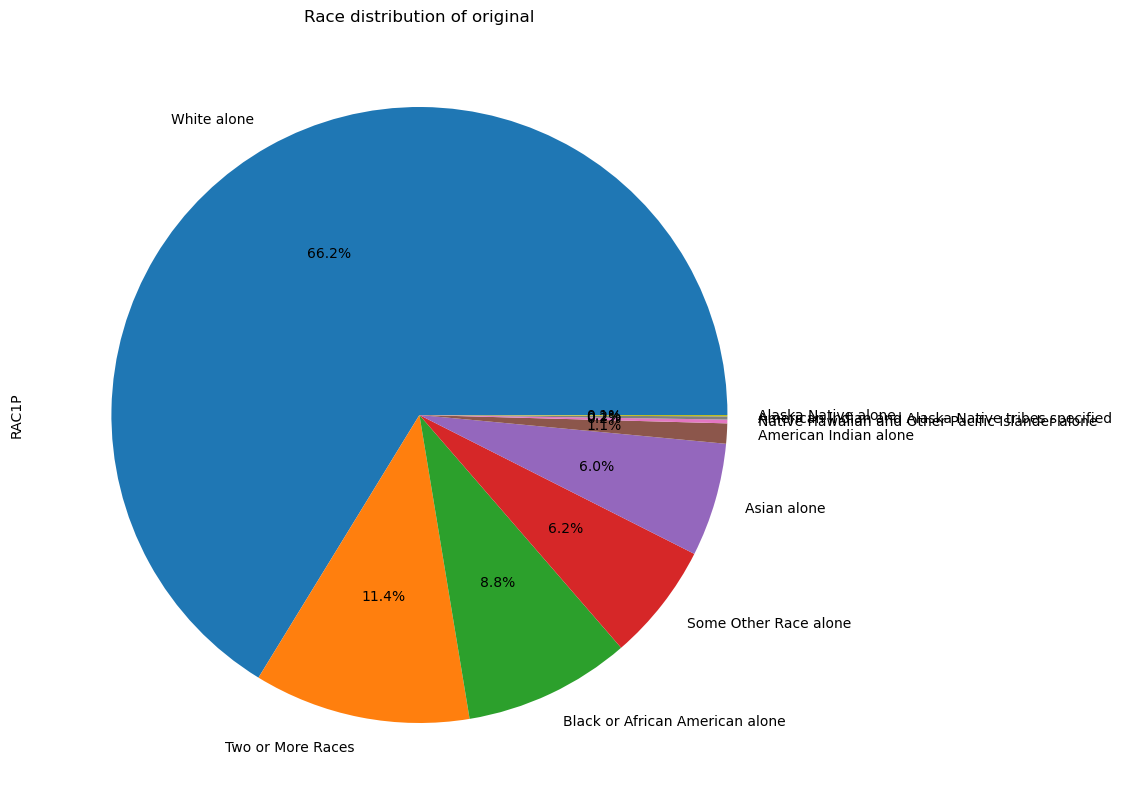

In [30]:
fig, axs = plt.subplots(1,1, figsize=(18,10))
piechart("Race distribution of original", original, axs, 'RAC1P', race_label_mapping)
plt.show()
fig.savefig('plots/race-original.png', bbox_inches='tight')

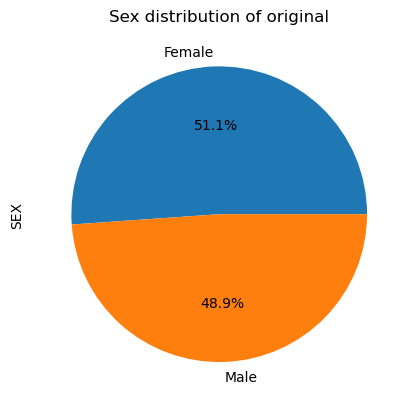

In [31]:
fig, axs = plt.subplots(1,1)
piechart("Sex distribution of original", original, axs, 'SEX', sex_label_mapping)
plt.show()
fig.savefig('plots/sex-original.png', bbox_inches='tight')

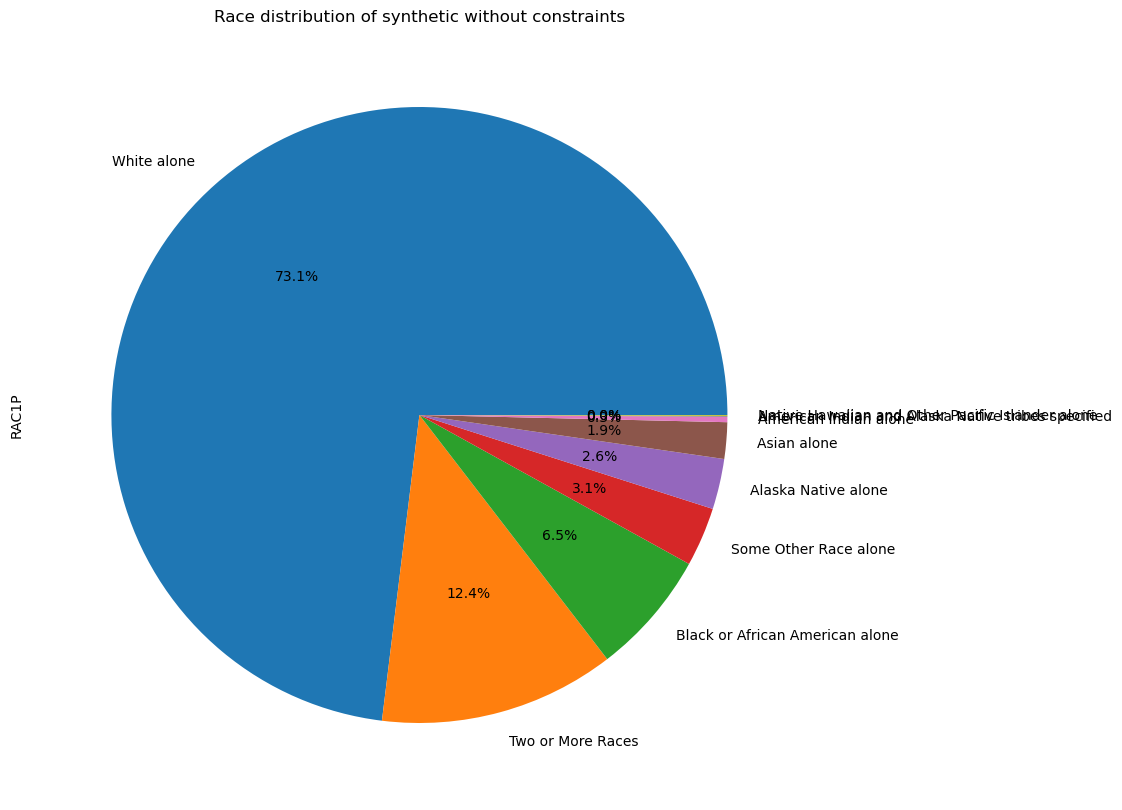

In [32]:
fig, axs = plt.subplots(1,1, figsize=(18,10))
piechart("Race distribution of synthetic without constraints", synthetic_data, axs, 'RAC1P', race_label_mapping)
plt.show()
fig.savefig('plots/race-synthetic-without-constraints.png', bbox_inches='tight')

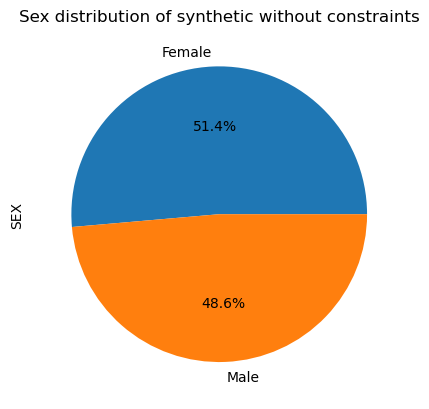

In [33]:
fig, axs = plt.subplots(1,1)
piechart("Sex distribution of synthetic without constraints", synthetic_data, axs, 'SEX', sex_label_mapping)
plt.show()
fig.savefig('plots/sex-synthetic-without-constraints.png', bbox_inches='tight')

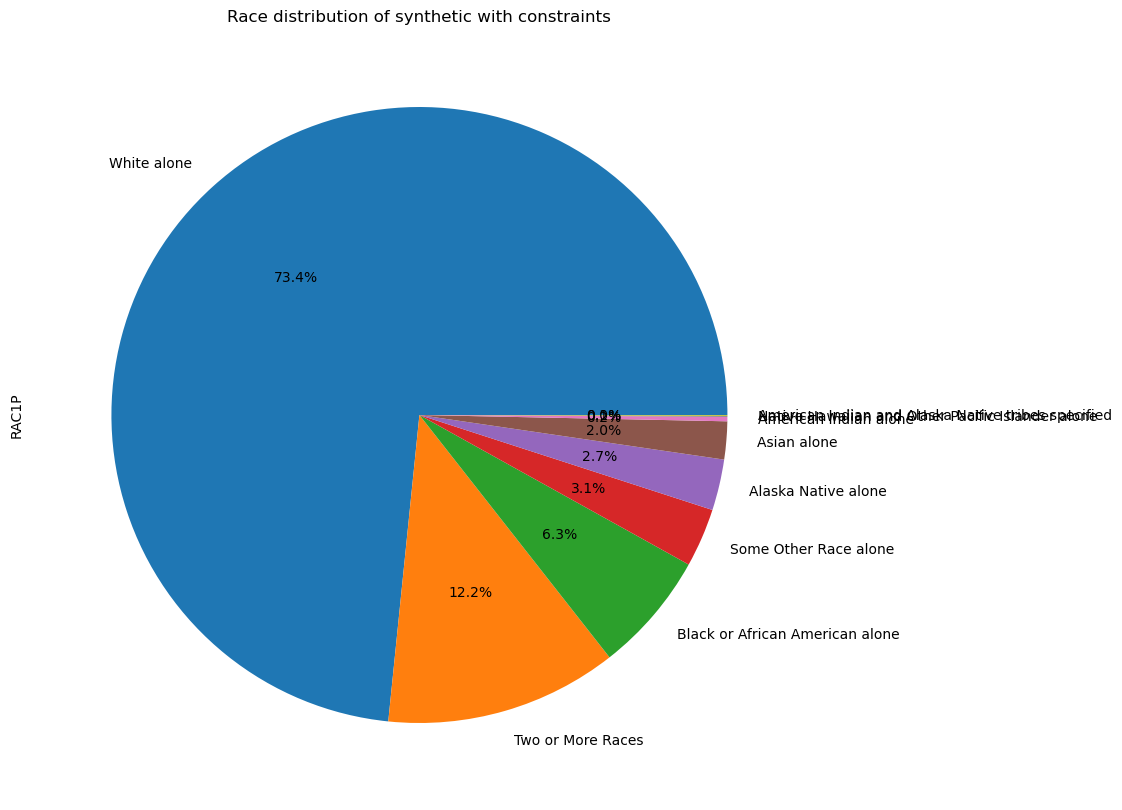

In [34]:
fig, axs = plt.subplots(1,1, figsize=(18,10))
piechart("Race distribution of synthetic with constraints", synthetic_data2, axs, 'RAC1P', race_label_mapping)
plt.show()
fig.savefig('plots/race-synthetic-with-constraints.png', bbox_inches='tight')

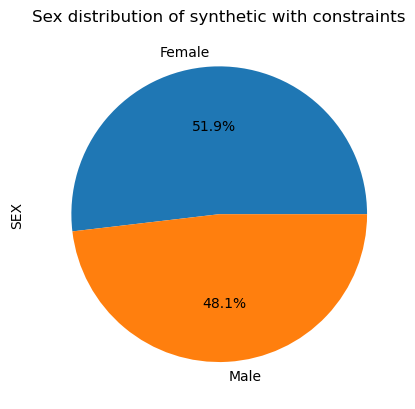

In [35]:
fig, axs = plt.subplots(1,1)
piechart("Sex distribution of synthetic with constraints", synthetic_data2, axs, 'SEX', sex_label_mapping)
plt.show()
fig.savefig('plots/sex-synthetic-with-constraints.png', bbox_inches='tight')

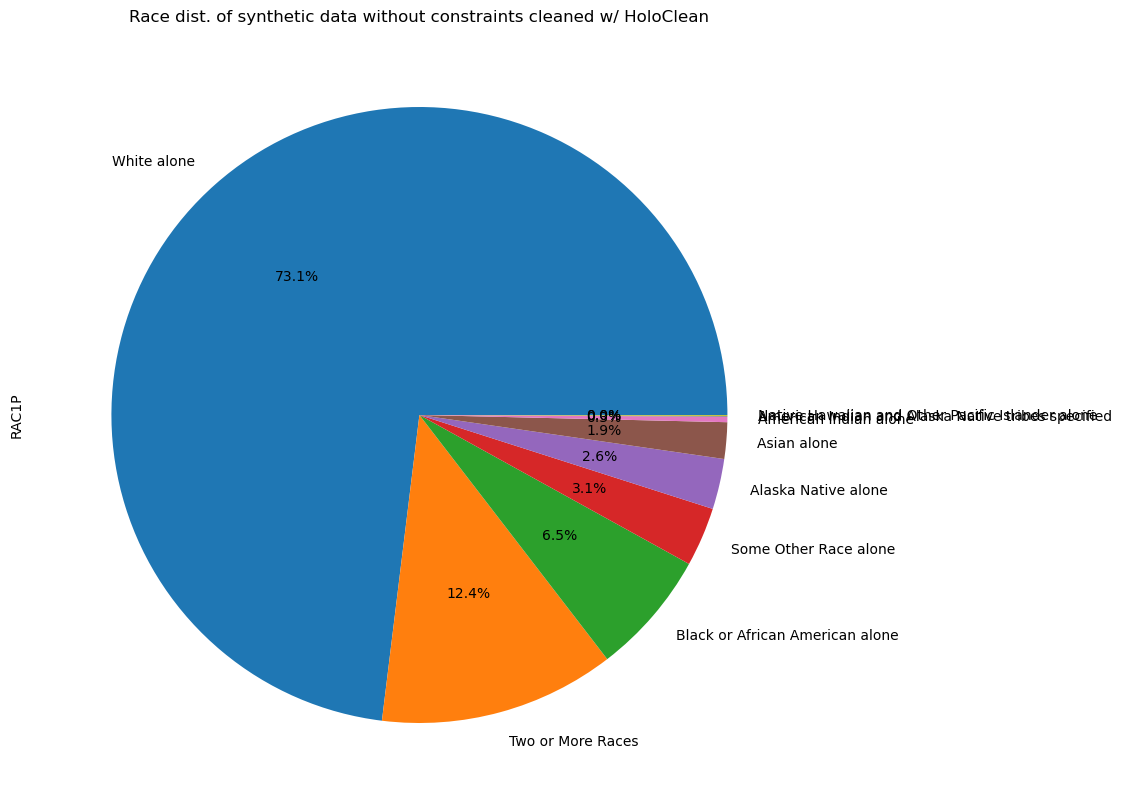

In [36]:
fig, axs = plt.subplots(1,1, figsize=(18,10))
piechart("Race dist. of synthetic data without constraints cleaned w/ HoloClean", holoclean_data, axs, 'RAC1P', race_label_mapping)
plt.show()
fig.savefig('plots/race-holoclean.png', bbox_inches='tight')

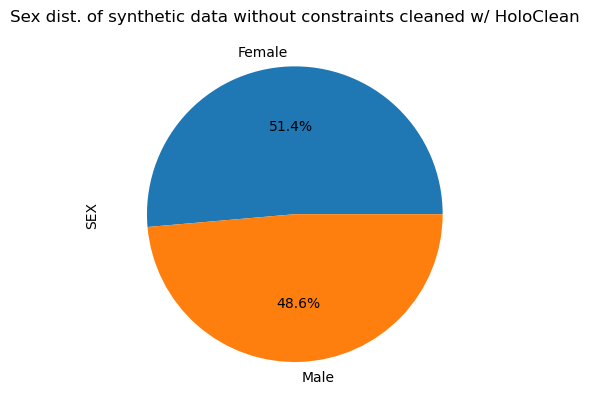

In [37]:
fig, axs = plt.subplots(1,1)
piechart("Sex dist. of synthetic data without constraints cleaned w/ HoloClean", holoclean_data, axs, 'SEX', sex_label_mapping)
plt.show()
fig.savefig('plots/sex-holoclean.png', bbox_inches='tight')

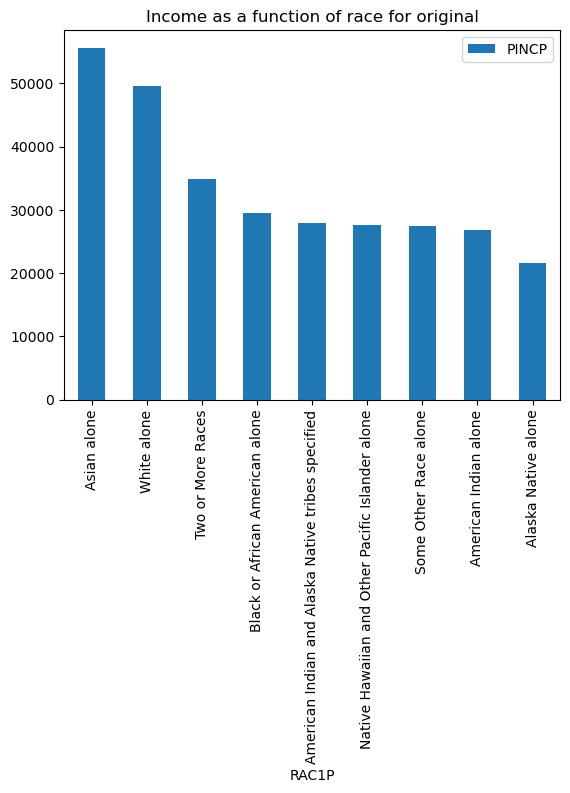

In [38]:
fig, axs = plt.subplots(1,1)
barplotForAvg("Income as a function of race for original", original, 'RAC1P', axs, race_label_mapping)
plt.show()
fig.savefig('plots/income-race-original.png', bbox_inches='tight')

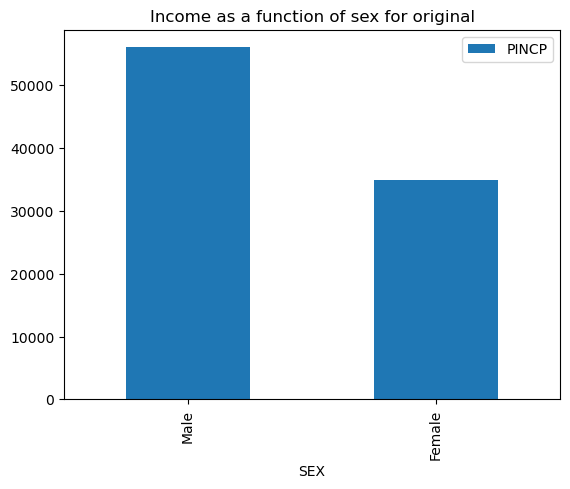

In [39]:
fig, axs = plt.subplots(1,1)
barplotForAvg("Income as a function of sex for original", original, 'SEX', axs, sex_label_mapping)
plt.show()
fig.savefig('plots/income-sex-original.png', bbox_inches='tight')

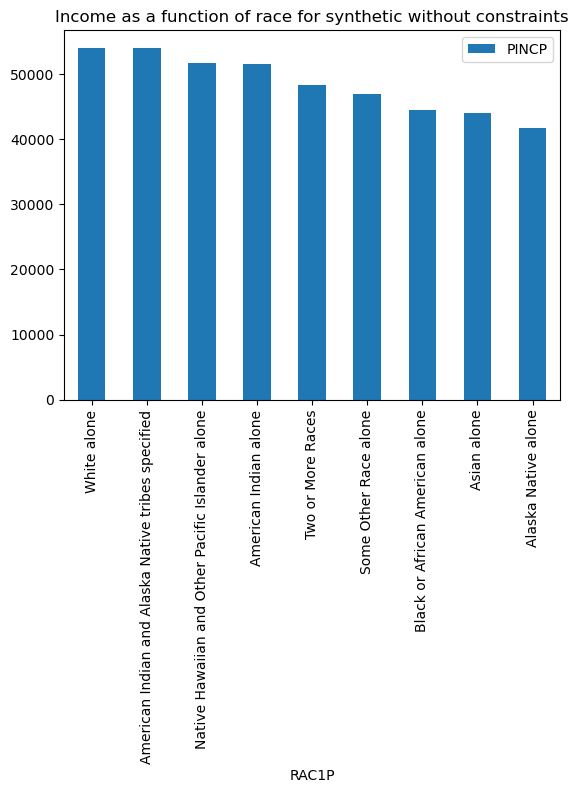

In [40]:
fig, axs = plt.subplots(1,1)
barplotForAvg("Income as a function of race for synthetic without constraints", synthetic_data, 'RAC1P', axs, race_label_mapping)

plt.show()
fig.savefig('plots/income-race-synthetic-without-constraints.png', bbox_inches='tight')

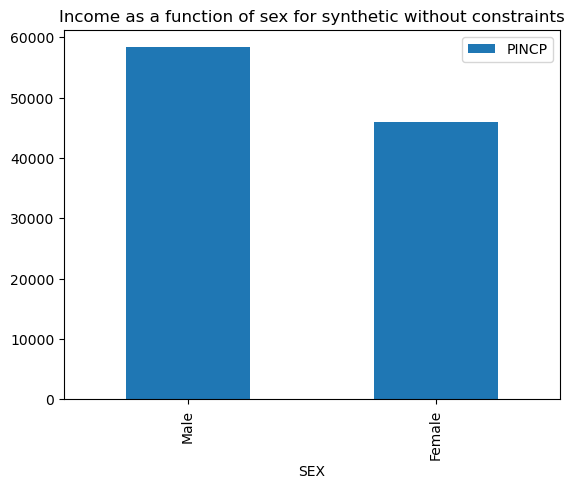

In [41]:
fig, axs = plt.subplots(1,1)
barplotForAvg("Income as a function of sex for synthetic without constraints", synthetic_data, 'SEX', axs, sex_label_mapping)
plt.show()
fig.savefig('plots/income-sex-synthetic-without-constraints.png', bbox_inches='tight')

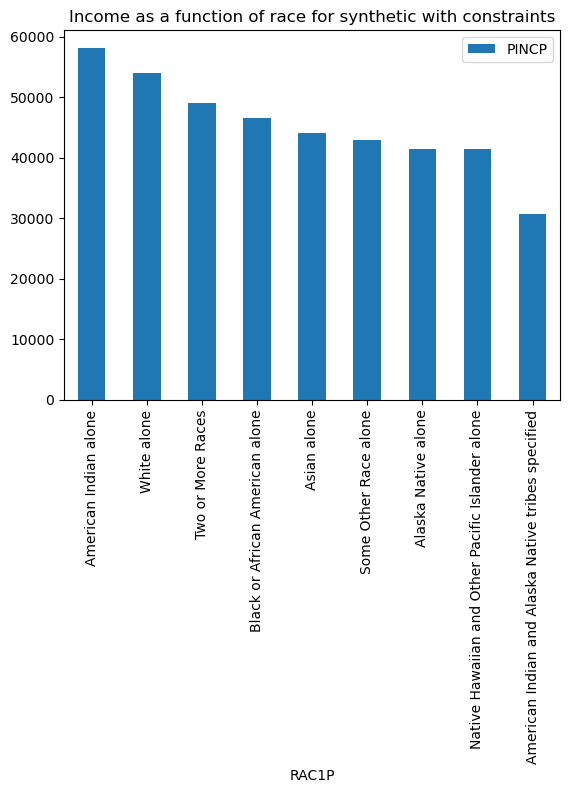

In [42]:
fig, axs = plt.subplots(1,1)
barplotForAvg("Income as a function of race for synthetic with constraints", synthetic_data2, 'RAC1P', axs, race_label_mapping)
plt.show()
fig.savefig('plots/income-race-synthetic-with-constraints.png', bbox_inches='tight')

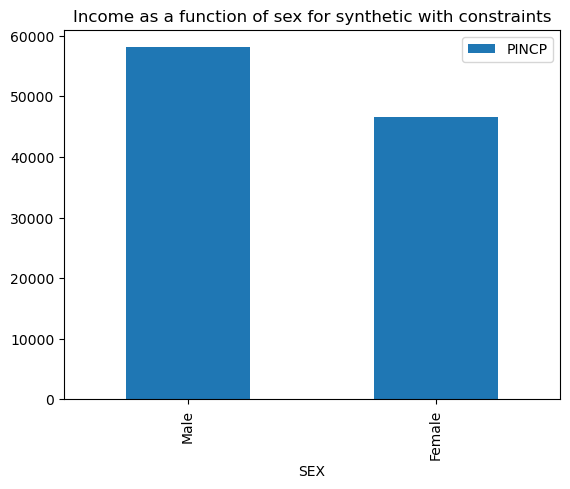

In [43]:
fig, axs = plt.subplots(1,1)
barplotForAvg("Income as a function of sex for synthetic with constraints", synthetic_data2, 'SEX', axs, sex_label_mapping)
plt.show()
fig.savefig('plots/income-sex-synthetic-with-constraints.png', bbox_inches='tight')

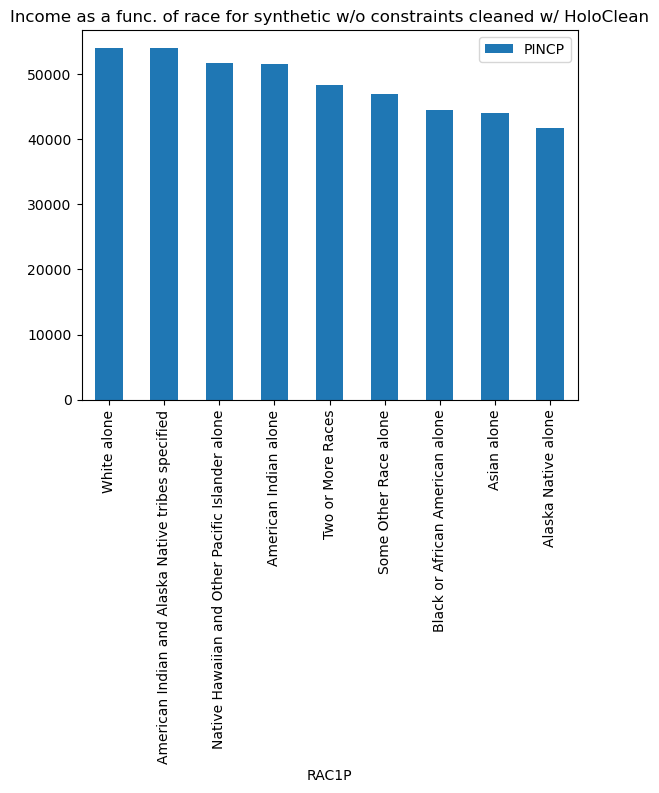

In [44]:
fig, axs = plt.subplots(1,1)
barplotForAvg("Income as a func. of race for synthetic w/o constraints cleaned w/ HoloClean", holoclean_data, 'RAC1P', axs, race_label_mapping)
plt.show()
fig.savefig('plots/income-race-holoclean.png', bbox_inches='tight')

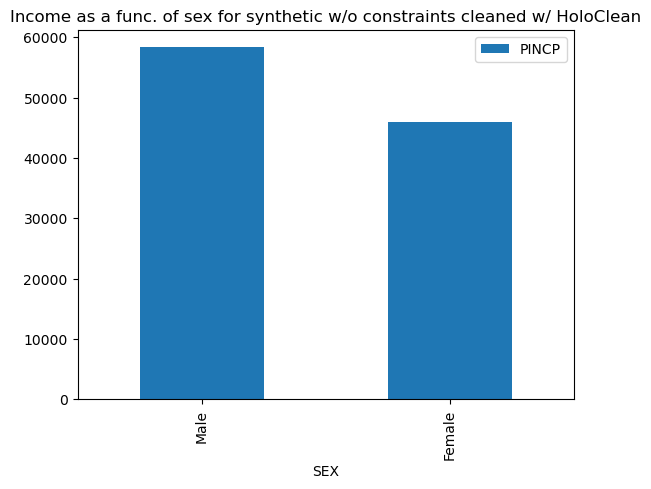

In [45]:
fig, axs = plt.subplots(1,1)
barplotForAvg("Income as a func. of sex for synthetic w/o constraints cleaned w/ HoloClean", holoclean_data, 'SEX', axs, sex_label_mapping)
plt.show()
fig.savefig('plots/income-sex-holoclean.png', bbox_inches='tight')

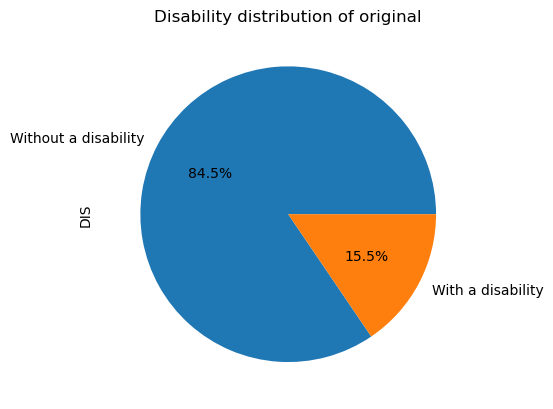

In [46]:
dis_label_mapping = {1: 'With a disability', 2: 'Without a disability'}

fig, axs = plt.subplots(1,1)
piechart("Disability distribution of original", original, axs, 'DIS', dis_label_mapping)
plt.show()
fig.savefig('plots/disability-original.png', bbox_inches='tight')

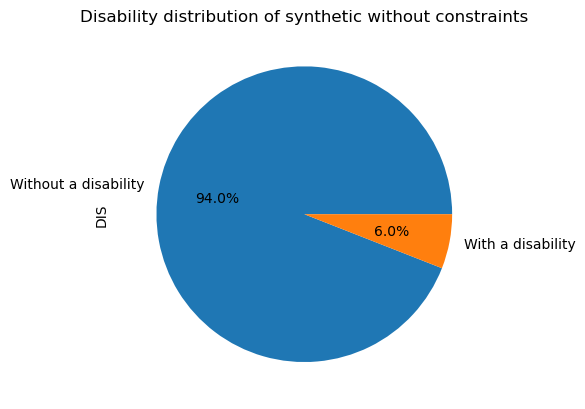

In [47]:
fig, axs = plt.subplots(1,1)
piechart("Disability distribution of synthetic without constraints", synthetic_data, axs, 'DIS', dis_label_mapping)
plt.show()
fig.savefig('plots/disability-synthetic-without-constraints.png', bbox_inches='tight')

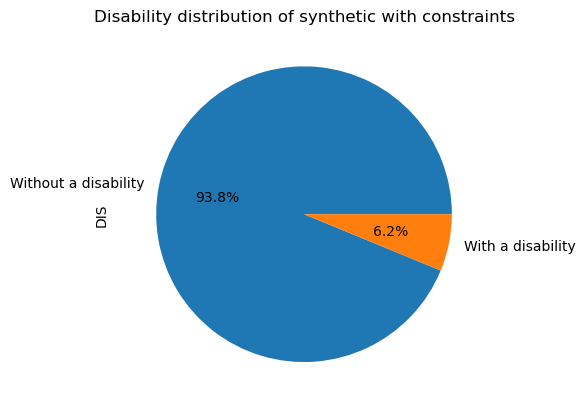

In [48]:
fig, axs = plt.subplots(1,1)
piechart("Disability distribution of synthetic with constraints", synthetic_data2, axs, 'DIS', dis_label_mapping)
plt.show()
fig.savefig('plots/disability-synthetic-with-constraints.png', bbox_inches='tight')

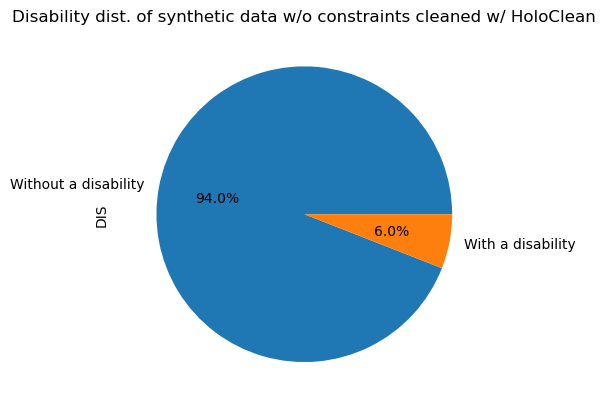

In [49]:
fig, axs = plt.subplots(1,1)
piechart("Disability dist. of synthetic data w/o constraints cleaned w/ HoloClean", holoclean_data, axs, 'DIS', dis_label_mapping)
plt.show()
fig.savefig('plots/disability-holoclean.png', bbox_inches='tight')

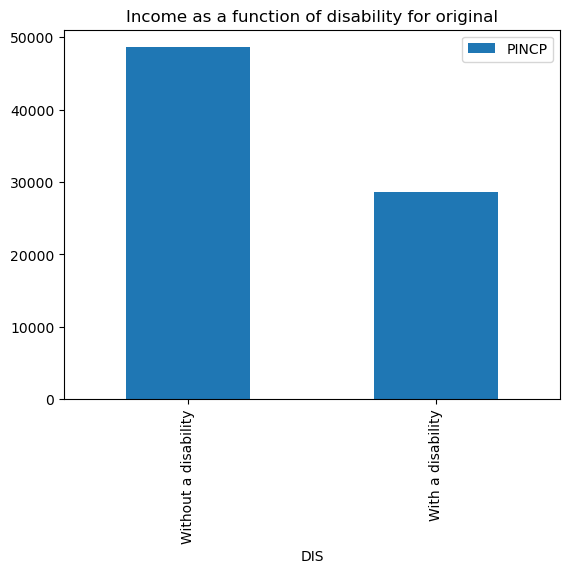

In [50]:
fig, axs = plt.subplots(1,1)
barplotForAvg("Income as a function of disability for original", original, 'DIS', axs, dis_label_mapping)
plt.show()
fig.savefig('plots/income-disability-original.png', bbox_inches='tight')

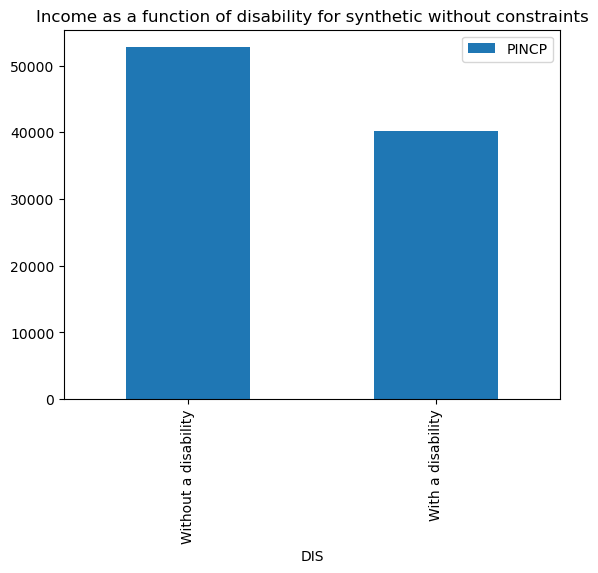

In [51]:
fig, axs = plt.subplots(1,1)
barplotForAvg("Income as a function of disability for synthetic without constraints", synthetic_data, 'DIS', axs, dis_label_mapping)
plt.show()
fig.savefig('plots/income-disability-synthetic-without-constraints.png', bbox_inches='tight')

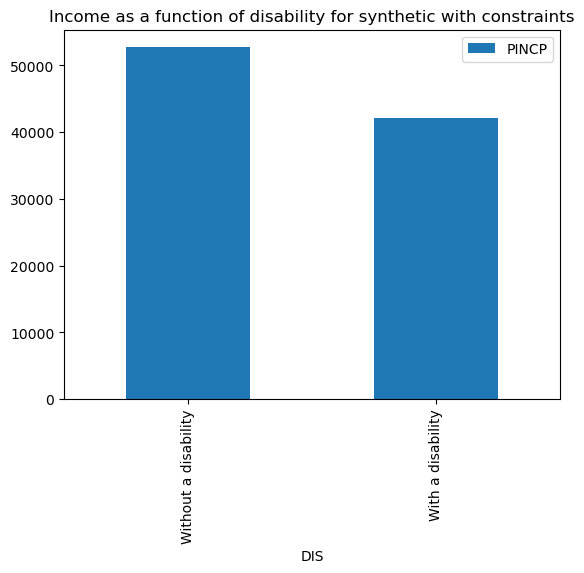

In [52]:
fig, axs = plt.subplots(1,1)
barplotForAvg("Income as a function of disability for synthetic with constraints", synthetic_data2, 'DIS', axs, dis_label_mapping)
plt.show()
fig.savefig('plots/income-disability-synthetic-with-constraints.png', bbox_inches='tight')

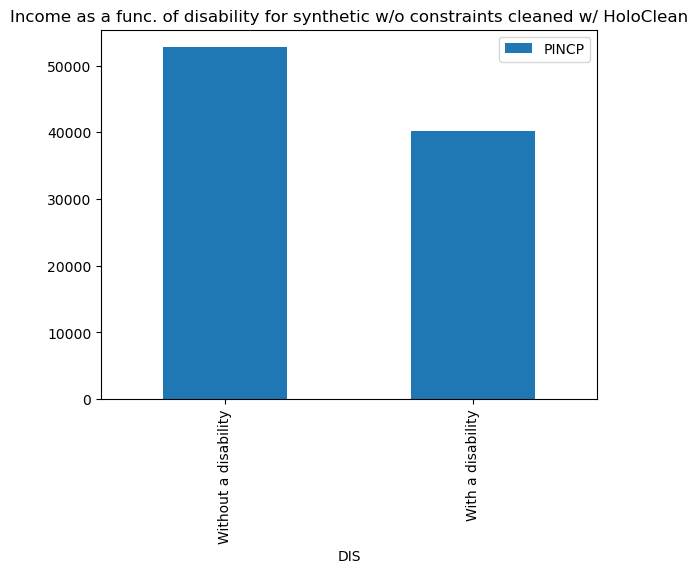

In [53]:
fig, axs = plt.subplots(1,1)
barplotForAvg("Income as a func. of disability for synthetic w/o constraints cleaned w/ HoloClean", holoclean_data, 'DIS', axs, dis_label_mapping)
plt.show()
fig.savefig('plots/income-disability-holoclean.png', bbox_inches='tight')

Experiment where I inject errors to my database and take Holoclean to show that Data Cleaning systems do not maintain representations by default.

In [54]:
def replace_vals(val, possible_vals):
    new_val = val
    while new_val == val:
        new_val = np.random.choice(possible_vals)
    return new_val

def insert_errors(df, alpha, column):
    df_copy = df.copy()
    random_sample = df_copy.sample(frac=alpha)
    print(df_copy[column].unique())
    df_copy.loc[random_sample.index, column] = df_copy.loc[random_sample.index, column].apply(lambda val: replace_vals(val, df_copy[column].unique()))
    return df_copy

experiment_data = insert_errors(original, 0.001, 'REGION')
display(original.compare(experiment_data))
experiment_data2 = insert_errors(experiment_data, 0.001, 'NATIVITY')
display(original.compare(experiment_data2))

print(satisfiesFD(experiment_data2,'ST','REGION'))
print(satisfiesFD(experiment_data2,'CIT','NATIVITY'))

[3 4 1 2 9]


REGION      
        self other
1238     4.0   9.0
2148     4.0   1.0
5196     4.0   1.0
6235     1.0   2.0
6261     1.0   9.0
6602     3.0   1.0
6986     3.0   4.0
7823     3.0   1.0
8114     3.0   4.0
8823     3.0   4.0
10054    2.0   9.0
11475    2.0   4.0
13158    3.0   9.0
14379    1.0   3.0
15315    2.0   4.0
15324    2.0   3.0
17917    1.0   9.0
17984    1.0   9.0
18301    1.0   2.0
18932    1.0   2.0
19508    1.0   4.0
19593    1.0   2.0
19964    1.0   9.0
21700    3.0   4.0
22714    2.0   3.0
24448    1.0   2.0
24856    1.0   3.0
25207    1.0   9.0
25552    1.0   9.0
25658    1.0   3.0
28876    3.0   2.0
31459    4.0   1.0
32586    9.0   1.0

[1 2]


REGION       NATIVITY      
        self other     self other
100      NaN   NaN      1.0   2.0
878      NaN   NaN      1.0   2.0
1238     4.0   9.0      NaN   NaN
1578     NaN   NaN      1.0   2.0
2148     4.0   1.0      NaN   NaN
...      ...   ...      ...   ...
29157    NaN   NaN      1.0   2.0
29859    NaN   NaN      1.0   2.0
30423    NaN   NaN      1.0   2.0
31459    4.0   1.0      NaN   NaN
32586    9.0   1.0      NaN   NaN

[66 rows x 4 columns]

False
False


In [55]:
print(numberOfViolations(original, 'ST', 'REGION'))
print(numberOfViolations(experiment_data2, 'ST', 'REGION'))

/var/folders/2v/h3nv4s8x3wdgrb7zrb22vvt00000gn/T/ipykernel_46750/2594168524.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merging_data = merging_data.append(merging_data.iloc[-1], ignore_index=True)


0 pairs of tuples violate the ST -> REGION FD. The maximum possible violations are 536428635. The percentage is 0.000%


/var/folders/2v/h3nv4s8x3wdgrb7zrb22vvt00000gn/T/ipykernel_46750/2594168524.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merging_data = merging_data.append(merging_data.iloc[-1], ignore_index=True)


42806 pairs of tuples violate the ST -> REGION FD. The maximum possible violations are 536428635. The percentage is 0.008%


In [56]:
experiment_data2.to_csv('experiment_data.csv',index=False)

In [57]:
experiment_data2.compare(original)

REGION       NATIVITY      
        self other     self other
100      NaN   NaN      2.0   1.0
878      NaN   NaN      2.0   1.0
1238     9.0   4.0      NaN   NaN
1578     NaN   NaN      2.0   1.0
2148     1.0   4.0      NaN   NaN
...      ...   ...      ...   ...
29157    NaN   NaN      2.0   1.0
29859    NaN   NaN      2.0   1.0
30423    NaN   NaN      2.0   1.0
31459    1.0   4.0      NaN   NaN
32586    1.0   9.0      NaN   NaN

[66 rows x 4 columns]

In [58]:
import psycopg2

# Establish a connection to the PostgreSQL database
conn = psycopg2.connect(
    database="holo",
    user="holocleanuser",
    password="abcd1234"
)

# Execute an SQL query and create a dataframe hospital_repaired
holoclean_experiment_data = pd.read_sql("SELECT * FROM experiment_data_repaired", conn).iloc[:, 1:]

conn.close()

/Users/kushagraghosh/opt/anaconda3/lib/python3.8/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [59]:
display(holoclean_experiment_data)

,RAC1P,SEX,REGION,PINCP,ST,COW,CIT,NATIVITY,MSP,SCHL,DIS,MIL
0,9,2,1,450.0,1,1.0,1,2,6.0,16.0,2,4.0
1,1,1,3,0.0,1,1.0,1,1,4.0,12.0,2,4.0
2,2,1,2,1000.0,1,1.0,1,1,6.0,16.0,2,4.0
3,1,1,3,0.0,1,_nan_,1,2,3.0,13.0,2,4.0
4,1,2,2,0.0,1,_nan_,1,1,6.0,6.0,1,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
32750,8,1,1,_nan_,72,_nan_,2,1,_nan_,8.0,2,4.0
32751,9,2,1,229800.0,72,1.0,1,1,4.0,23.0,2,4.0
32752,9,2,3,960.0,72,_nan_,2,1,3.0,1.0,1,4.0
32753,2,2,9,_nan_,72,_nan_,2,1,_nan_,4.0,2,4.0


In [60]:
print(holoclean_experiment_data.isna().sum().sum())
print(holoclean_experiment_data.eq('_nan_').sum().sum())
holoclean_experiment_data = holoclean_experiment_data.replace('_nan_', np.nan)

def make_col_int(df, *args):
    for col in args:
        df[col] = df[col].astype(float)
        df[col] = df[col].astype(int)
def make_col_float(df, *args):
    for col in args:
        df[col] = df[col].astype(float)
        
make_col_int(holoclean_experiment_data, 'RAC1P', 'SEX', 'REGION', 'ST', 'CIT', 'NATIVITY', 'DIS')
make_col_float(holoclean_experiment_data, 'PINCP', 'COW', 'MSP', 'SCHL', 'MIL')

0
25597


In [61]:
display(holoclean_experiment_data)

,RAC1P,SEX,REGION,PINCP,ST,COW,CIT,NATIVITY,MSP,SCHL,DIS,MIL
0,9,2,1,450.0,1,1.0,1,2,6.0,16.0,2,4.0
1,1,1,3,0.0,1,1.0,1,1,4.0,12.0,2,4.0
2,2,1,2,1000.0,1,1.0,1,1,6.0,16.0,2,4.0
3,1,1,3,0.0,1,NaN,1,2,3.0,13.0,2,4.0
4,1,2,2,0.0,1,NaN,1,1,6.0,6.0,1,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
32750,8,1,1,NaN,72,NaN,2,1,NaN,8.0,2,4.0
32751,9,2,1,229800.0,72,1.0,1,1,4.0,23.0,2,4.0
32752,9,2,3,960.0,72,NaN,2,1,3.0,1.0,1,4.0
32753,2,2,9,NaN,72,NaN,2,1,NaN,4.0,2,4.0


To check how many tuples were changed using the HoloClean repair process on the original data with random changes:

In [62]:
comparing = experiment_data2.compare(holoclean_experiment_data)
display(comparing)
print(f"{round(comparing.isna().eq(False).sum().sum()/2)} cells were changed")
print(f"{comparing.shape[0]} tuples (rows) out of a total {synthetic_data.shape[0]} were changed")

REGION       NATIVITY        MIL      
        self other     self other self other
0        3.0   1.0      1.0   2.0  NaN   NaN
2        3.0   2.0      NaN   NaN  NaN   NaN
3        NaN   NaN      1.0   2.0  NaN   NaN
4        3.0   2.0      NaN   NaN  NaN   NaN
5        3.0   1.0      NaN   NaN  NaN   NaN
...      ...   ...      ...   ...  ...   ...
32750    9.0   1.0      NaN   NaN  NaN   4.0
32751    9.0   1.0      NaN   NaN  NaN   NaN
32752    9.0   3.0      NaN   NaN  NaN   NaN
32753    NaN   NaN      NaN   NaN  NaN   4.0
32754    9.0   2.0      NaN   NaN  NaN   NaN

[25323 rows x 6 columns]

28728 cells were changed
25323 tuples (rows) out of a total 32755 were changed


Since the Holoclean and other repair algorithms are probabilistic and not deterministic, we need to find the number of violations before repairing (after synthetic data generation) and after cleaning/repair (for Holoclean and Muse). For example in HoloClean, if the number of violations for functional dependencies is beyond some percentage in the data, it won't do anything to repair, so we should know if Holoclean gave up and did nothing.

In [63]:
print(numberOfViolations(experiment_data2, 'ST', 'REGION'))
print(numberOfViolations(holoclean_experiment_data, 'ST', 'REGION'))

/var/folders/2v/h3nv4s8x3wdgrb7zrb22vvt00000gn/T/ipykernel_46750/2594168524.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merging_data = merging_data.append(merging_data.iloc[-1], ignore_index=True)


42806 pairs of tuples violate the ST -> REGION FD. The maximum possible violations are 536428635. The percentage is 0.008%


/var/folders/2v/h3nv4s8x3wdgrb7zrb22vvt00000gn/T/ipykernel_46750/2594168524.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merging_data = merging_data.append(merging_data.iloc[-1], ignore_index=True)


18164072 pairs of tuples violate the ST -> REGION FD. The maximum possible violations are 536428635. The percentage is 3.386%


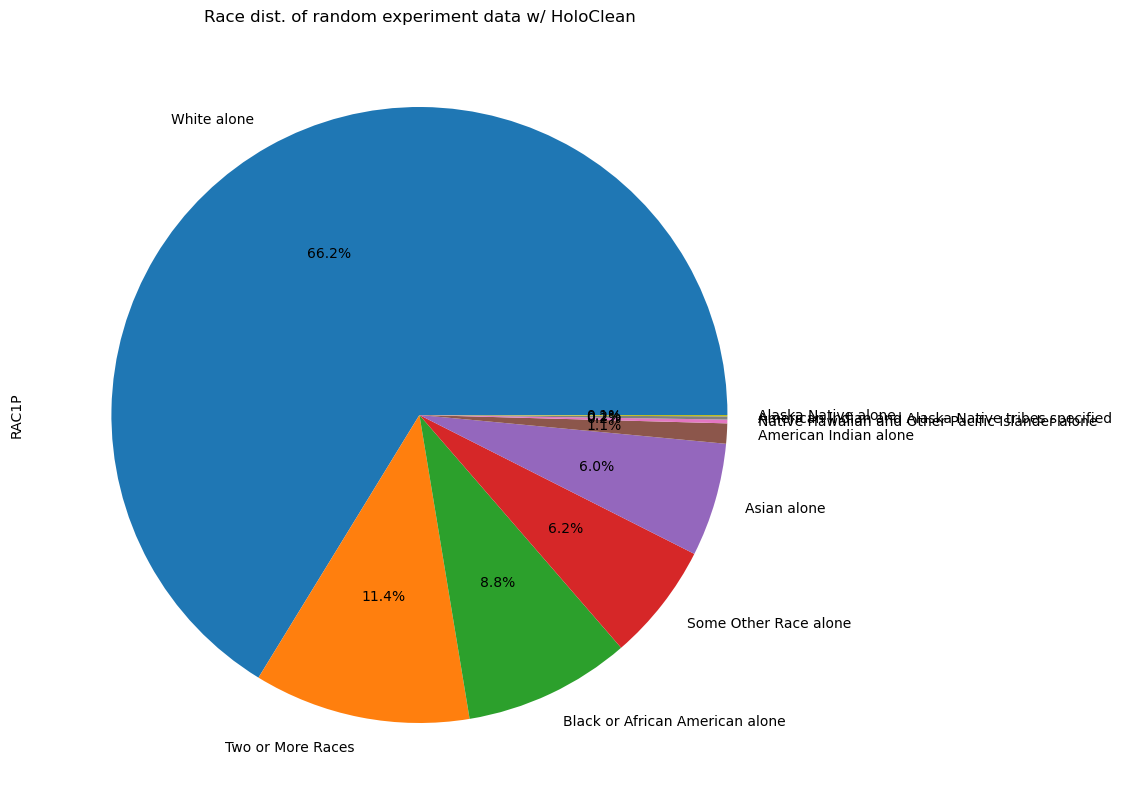

In [64]:
fig, axs = plt.subplots(1,1, figsize=(18,10))
piechart("Race dist. of random experiment data w/ HoloClean", holoclean_experiment_data, axs, 'RAC1P', race_label_mapping)
plt.show()
fig.savefig('plots/race-experiment-holoclean.png', bbox_inches='tight')

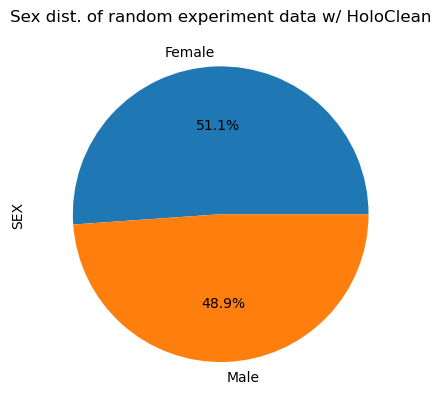

In [65]:
fig, axs = plt.subplots(1,1)
piechart("Sex dist. of random experiment data w/ HoloClean", holoclean_experiment_data, axs, 'SEX', sex_label_mapping)
plt.show()
fig.savefig('plots/sex-experiment-holoclean.png', bbox_inches='tight')

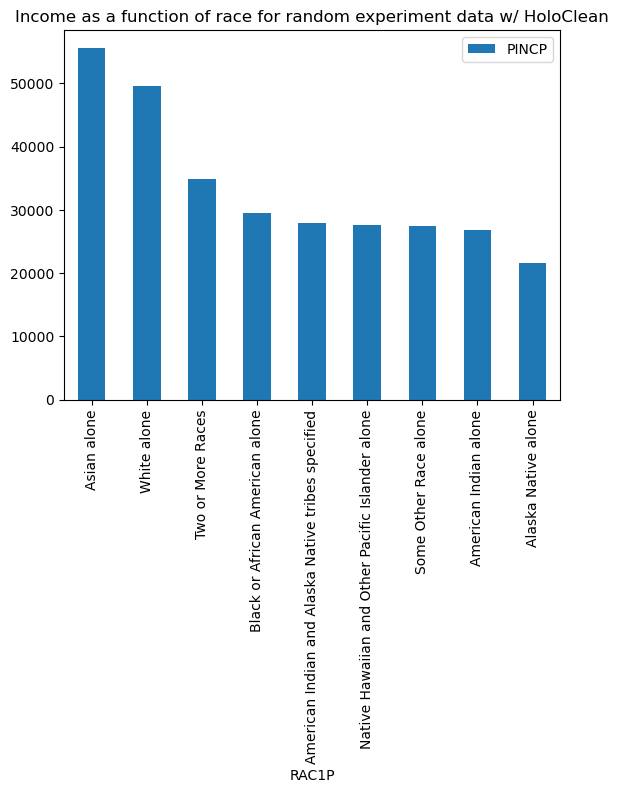

In [66]:
fig, axs = plt.subplots(1,1)
barplotForAvg("Income as a function of race for random experiment data w/ HoloClean", holoclean_experiment_data, 'RAC1P', axs, race_label_mapping)
plt.show()
fig.savefig('plots/income-race-experiment-holoclean.png', bbox_inches='tight')

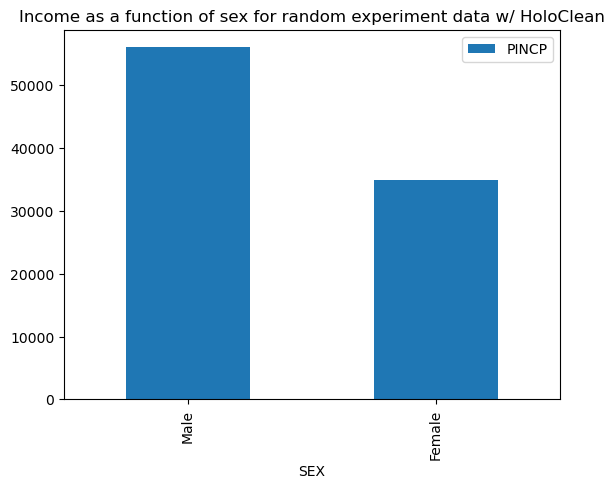

In [67]:
fig, axs = plt.subplots(1,1)
barplotForAvg("Income as a function of sex for random experiment data w/ HoloClean", holoclean_experiment_data, 'SEX', axs, sex_label_mapping)
plt.show()
fig.savefig('plots/income-sex-experiment-holoclean.png', bbox_inches='tight')

I created tables for how the numbers (frequency and average income) are changing for the 6 plots with the graphs below it. Each column for every graph. I have 1 set of tables for race, one for gender, one for disability, and these tables will go in my report later.

In [68]:

def frequency_table(dfs, column, dfNames, label_mapping):
    series = []
    for df in dfs:
        #display(df[column].value_counts())
        series.append(df[column].value_counts())
    df = pd.concat(series, axis=1)
    df.columns = dfNames
    df = df.rename(index=label_mapping)
    return df
        
freq_table_race = frequency_table([original, synthetic_data, synthetic_data2, holoclean_data, holoclean_experiment_data], 'RAC1P', ['original', 'synthetic_no_constraints', 'synthetic_constraints', 'holoclean_data', 'holoclean_experiment_data'], race_label_mapping)
freq_table_sex = frequency_table([original, synthetic_data, synthetic_data2, holoclean_data, holoclean_experiment_data], 'SEX', ['original', 'synthetic_no_constraints', 'synthetic_constraints', 'holoclean_data', 'holoclean_experiment_data'], sex_label_mapping)
freq_table_dis = frequency_table([original, synthetic_data, synthetic_data2, holoclean_data, holoclean_experiment_data], 'DIS', ['original', 'synthetic_no_constraints', 'synthetic_constraints', 'holoclean_data', 'holoclean_experiment_data'], dis_label_mapping)

display(freq_table_race)
display(freq_table_sex)
display(freq_table_dis)

,original,synthetic_no_constraints,synthetic_constraints,holoclean_data,holoclean_experiment_data
White alone,21700,23930,24038,23930,21700
Two or More Races,3720,4055,3996,4055,3720
Black or African American alone,2868,2139,2078,2139,2868
Some Other Race alone,2028,1016,1009,1016,2028
Asian alone,1951,626,651,626,1951
American Indian alone,346,92,76,92,346
Native Hawaiian and Other Pacific Islander alone,64,15,17,15,64
American Indian and Alaska Native tribes specified,55,15,14,15,55
Alaska Native alone,23,867,876,867,23


,original,synthetic_no_constraints,synthetic_constraints,holoclean_data,holoclean_experiment_data
Female,16742,16830,16986,16830,16742
Male,16013,15925,15769,15925,16013


,original,synthetic_no_constraints,synthetic_constraints,holoclean_data,holoclean_experiment_data
Without a disability,27676,30806,30716,30806,27676
With a disability,5079,1949,2039,1949,5079


In [69]:
def avg_income_table(dfs, column, dfNames, label_mapping):
    series = []
    for df in dfs:
        averages = df.pivot_table(values='PINCP', index=column, aggfunc='mean')
        series.append(averages.round(2))
    df = pd.concat(series, axis=1)
    df.columns = dfNames
    df = df.rename(index=label_mapping)

    return df
        
avg_table_race = avg_income_table([original, synthetic_data, synthetic_data2, holoclean_data, holoclean_experiment_data], 'RAC1P', ['original', 'synthetic_no_constraints', 'synthetic_constraints', 'holoclean_data', 'holoclean_experiment_data'], race_label_mapping)
avg_table_sex = avg_income_table([original, synthetic_data, synthetic_data2, holoclean_data, holoclean_experiment_data], 'SEX', ['original', 'synthetic_no_constraints', 'synthetic_constraints', 'holoclean_data', 'holoclean_experiment_data'], sex_label_mapping)
avg_table_dis = avg_income_table([original, synthetic_data, synthetic_data2, holoclean_data, holoclean_experiment_data], 'DIS', ['original', 'synthetic_no_constraints', 'synthetic_constraints', 'holoclean_data', 'holoclean_experiment_data'], dis_label_mapping)

display(avg_table_race)
display(avg_table_sex)
display(avg_table_dis)

,original,synthetic_no_constraints,synthetic_constraints,holoclean_data,holoclean_experiment_data
RAC1P,,,,,
White alone,49618.61,54082.48,54073.43,54082.48,49618.61
Black or African American alone,29455.53,44449.36,46502.94,44449.36,29455.53
American Indian alone,26766.04,51523.90,58190.72,51523.90,26766.04
Alaska Native alone,21656.88,41788.86,41473.14,41788.86,21656.88
American Indian and Alaska Native tribes specified,27867.66,53977.76,30602.36,53977.76,27867.66
Asian alone,55641.93,44017.75,44043.57,44017.75,55641.93
Native Hawaiian and Other Pacific Islander alone,27642.14,51670.43,41370.53,51670.43,27642.14
Some Other Race alone,27483.22,46886.92,42972.87,46886.92,27483.22
Two or More Races,34931.30,48285.00,49000.56,48285.00,34931.30


,original,synthetic_no_constraints,synthetic_constraints,holoclean_data,holoclean_experiment_data
SEX,,,,,
Male,56017.13,58320.99,58070.75,58320.99,56017.13
Female,34852.28,45955.74,46523.36,45955.74,34852.28


,original,synthetic_no_constraints,synthetic_constraints,holoclean_data,holoclean_experiment_data
DIS,,,,,
With a disability,28672.16,40242.56,42104.98,40242.56,28672.16
Without a disability,48608.09,52741.40,52735.90,52741.40,48608.09


In [70]:
#The reference to the data, what I did too the data, what FD i used, what is the data generation system I used for synthetic data, how many FD violatoons, distiiultions from the graphs, we need to know the same statistics and number of violations
#Have a section of description of data and data processing
#bib file for references in Overleaf

#Synthetic data generation and blind cleaning --> distributions of interest change, representation of different subpopulation for different subgroups in the data, at least preserve the truthgul original distributions, otherwise, for leaning we are not sending the right thing. Distributon in some view (query answrr) for example income vs gender,race, being truthful to that or not. Distributin change may be ok but ranking is the third type of problem that we want to preserve. 
#Repeat this for disability and age
#Adding the Muse graphs for all of this


In [71]:
#Whether the salary distributions constraints

#Given outcome of interest, try with different combination of functional dependencies, run synthtic data generator one at a time , see if the distribution changes of an attibute of interest varying some other parameters (race, age, gender), race, age, gender, insurance vs length of stay

# Given outcome of interest, try with different combination of functional dependencies, run synthtic data generator one at a time , see if the distribution changes of an attibute of interest varying some other parameters (race, age, gender), race, age, gender, insurance vs length of stay
# Repeat those plots for a combination of functional depenecy, whether the outcome of interest changes even if the denial constraints have or do not have nothing to do with the outcome of interest
# Adding constraints preserves the outcome of interest?  Motivate the need for generatting clean data satisfying constrains while preserving the distibutino of an outcome of interest. Seeing if there is an issue with the data generators of interest.

# Seee if the other data generators allow for functional dependency constraints

# data genration and data cleaning algorithms are imperfect when it comes to bias, these systems have limiations, messing up with bias or distributions or both, so we have to fiz something in those systems/problems
#original, synthetic constraints, synthetic data without constraints and then clean the data with holoclean, denian constraints, 
#add database_reset(db) before every time in line 76 of running_example.py